In [1]:
%matplotlib inline

import openxdf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def load_data(xdf_path, signal_path):
    xdf = openxdf.OpenXDF(xdf_path)
    signal = openxdf.Signal(xdf, signal_path)
    return xdf, signal


def select_rem_epochs(signal, scorer="Dennis"):
    staging = signal._xdf.dataframe(epochs=False, events=True)
    staging = staging[staging["Scorer"] == scorer].reset_index(drop=True)
    return staging[staging["Stage"] == "R"].reset_index(drop=True)


def select_rswa_events(signal, scorer="Dennis"):
    staging = signal._xdf.dataframe(epochs=False, events=True)
    staging = staging[staging["Scorer"] == scorer].reset_index(drop=True)
    staging = staging[
        staging["CEName"].isnull() | staging["CEName"].isin(["RSWA_T", "RSWA_P"])
    ]
    staging = staging[staging["CEName"].isin(["RSWA_T", "RSWA_P"])]
    return staging


def select_epoch(epoch, channel, signals_dict):
    start = (epoch - 1) * 30
    end = start + 30
    period = signals_dict[channel][start:end]
    return np.concatenate(period)


def plot_epoch(epoch, signals_dict, scoring_df):
    plot_signals = {}
    for channel in signals_dict.keys():
        plot_signals[channel] = select_epoch(epoch, channel, signals_dict)

    ## Plot channels
    fig, ax = plt.subplots(1)
    min_point, max_point = 0, 0
    for key in plot_signals.keys():
        len_key = len(plot_signals[key])
        x_time_axis = [i / (len_key / 30) for i in range(0, len_key)]
        min_point = min(min_point, np.min(plot_signals[key]))
        max_point = max(max_point, np.max(plot_signals[key]))
        ax.plot(x_time_axis, plot_signals[key])

    ## Add event annotations
    events = scoring_df[scoring_df["EpochNumber"] == epoch]
    if not events.size:
        return plt.show()

    for indx, row in events.iterrows():
        if row["CEName"] == "RSWA_P":
            ax.axvline(x=row["EpochTime"], linestyle="--", color="black")

        if row["CEName"] == "RSWA_T":
            x_start = float(row["EpochTime"])
            y_start = min_point
            width = float(row["Duration"])
            height = max_point - min_point
            rect = Rectangle((x_start, y_start), width, height, linewidth=1, fill=True, alpha=0.5, facecolor="grey")
            ax.add_patch(rect)

    return plt.show()


## Load Data

In [3]:
xdf, signal = load_data("../tests/data/test.xdf", "../tests/data/test.nkamp")

In [4]:
channels = signal.read_file(["Chin"])

In [5]:
rswa_events = select_rswa_events(signal)

## Plot a single epoch with phasic RSWA events

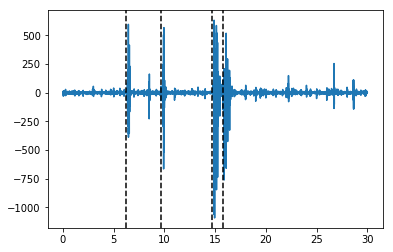

In [6]:
plot_epoch(550, channels, rswa_events)

## Plot all epochs with RSWA events

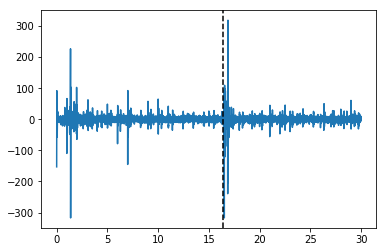

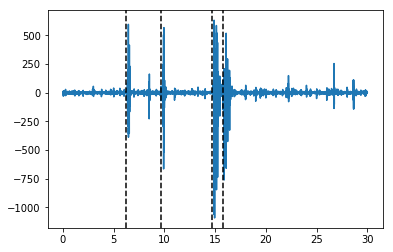

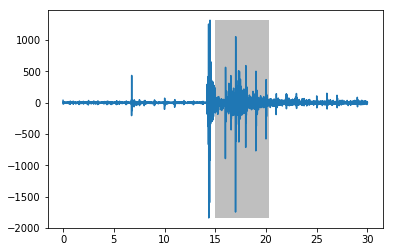

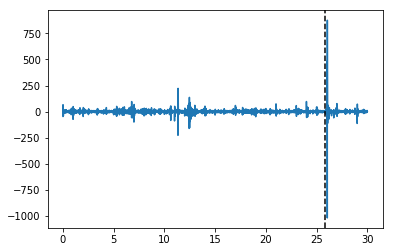

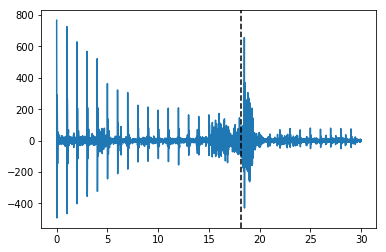

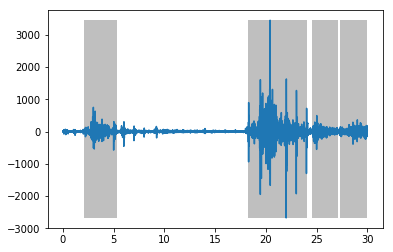

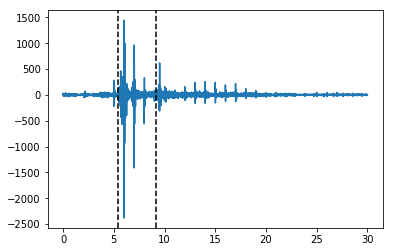

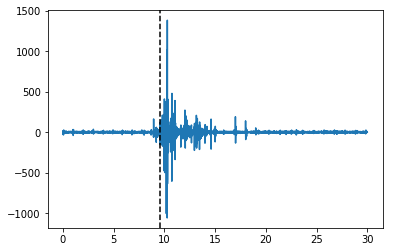

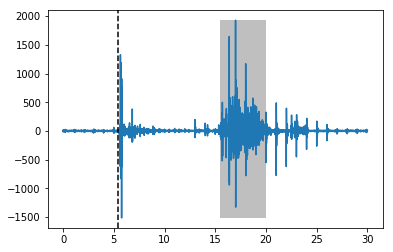

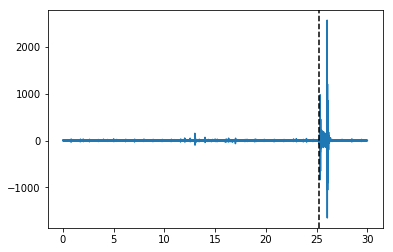

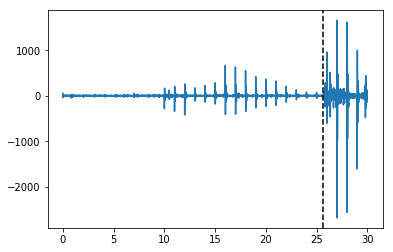

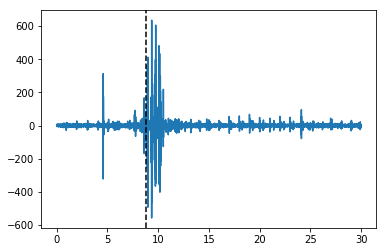

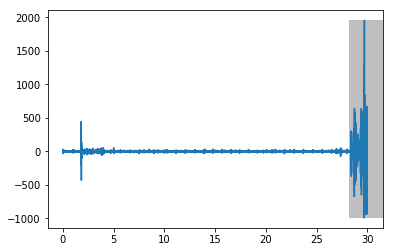

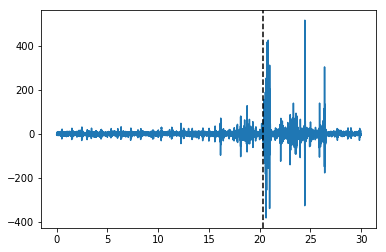

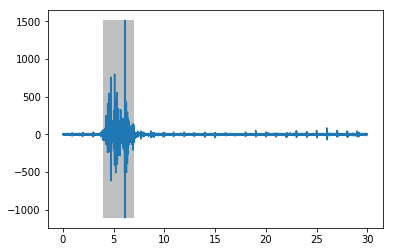

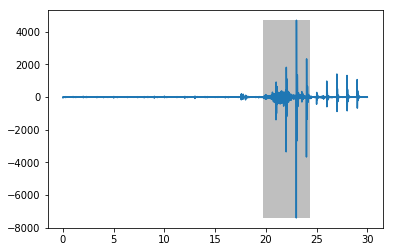

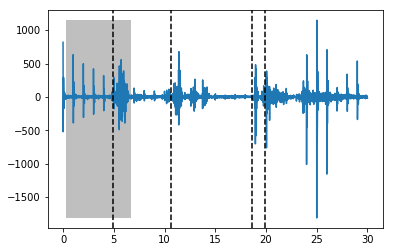

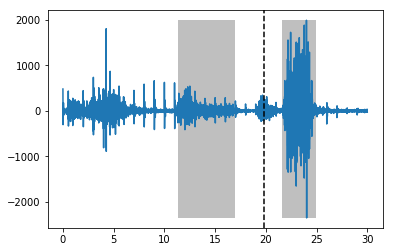

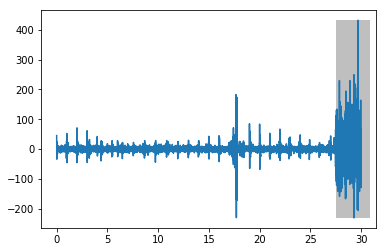

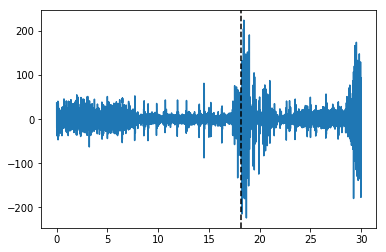

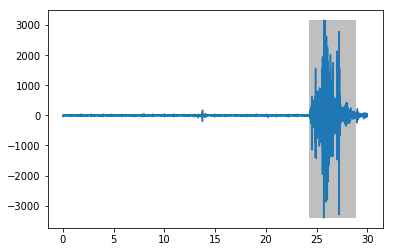

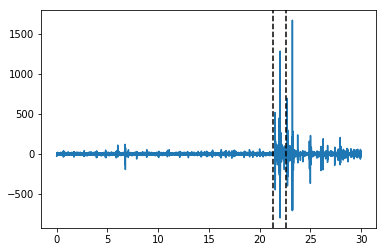

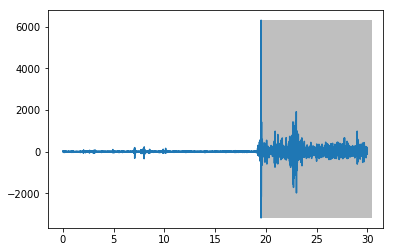

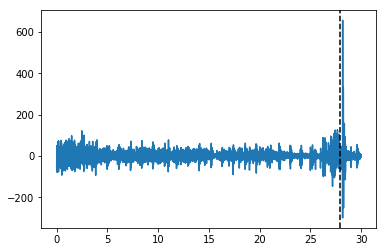

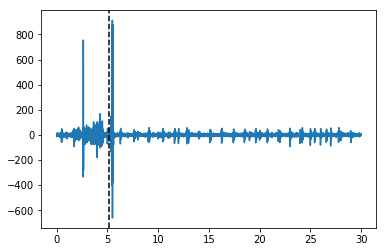

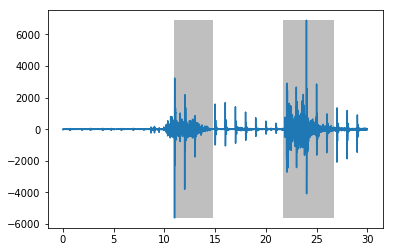

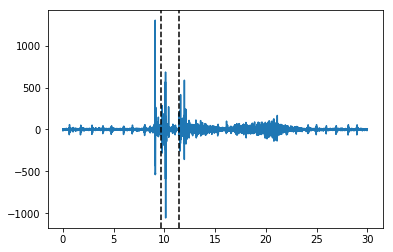

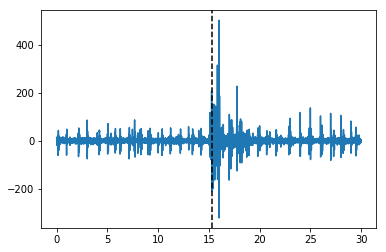

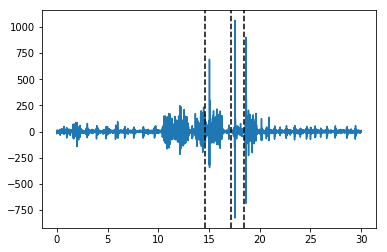

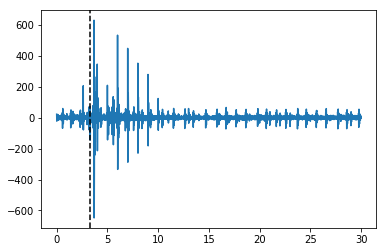

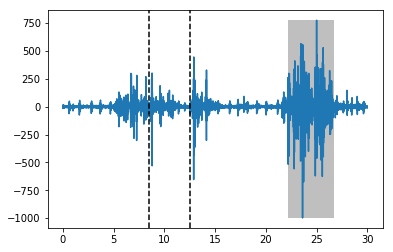

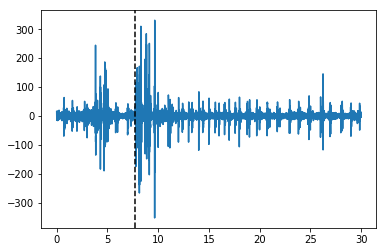

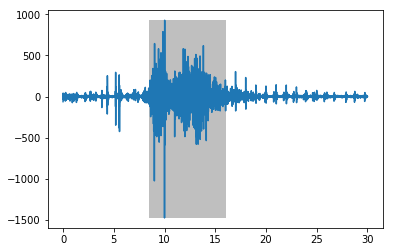

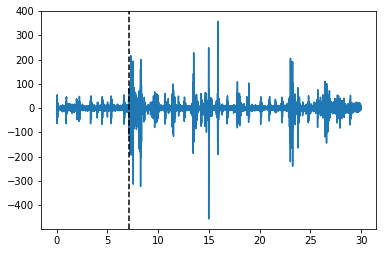

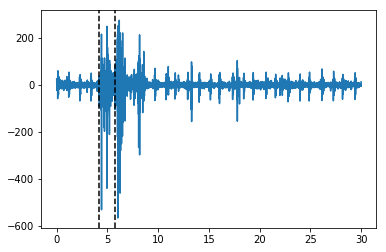

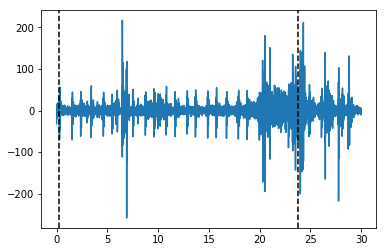

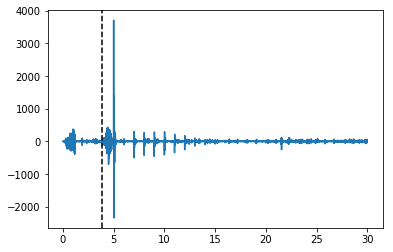

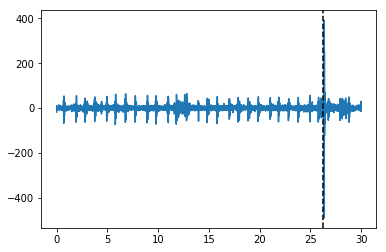

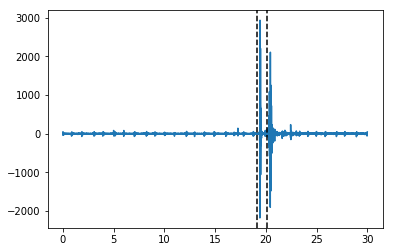

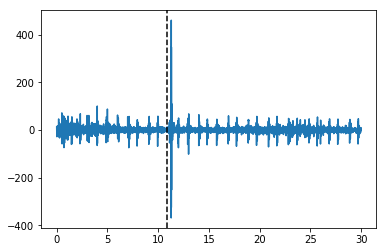

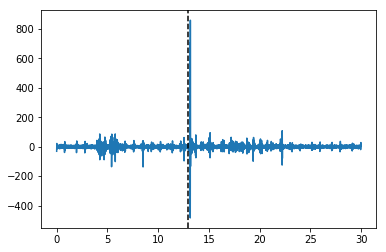

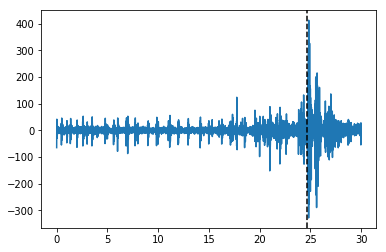

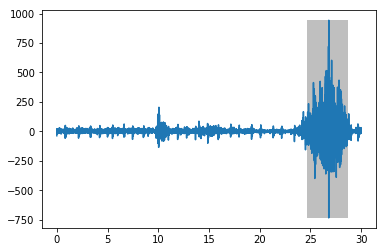

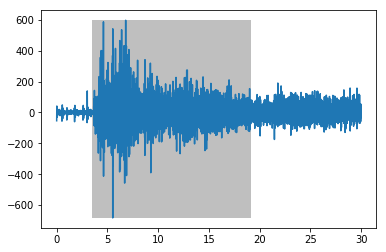

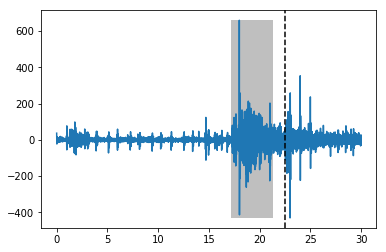

In [7]:
rswa_events = select_rswa_events(signal)
for epoch in rswa_events["EpochNumber"].unique():
    plot_epoch(epoch, channels, rswa_events)

## Plot all REM epochs

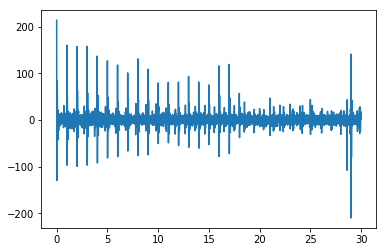

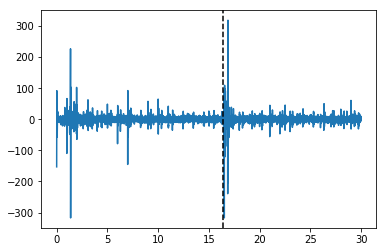

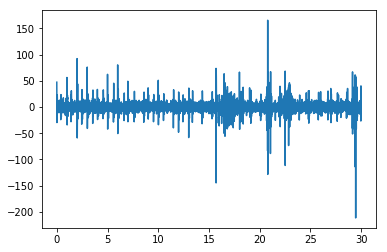

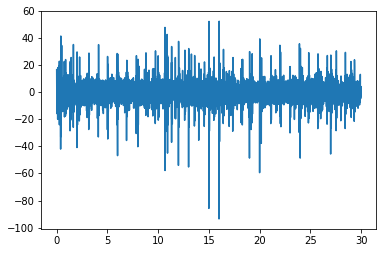

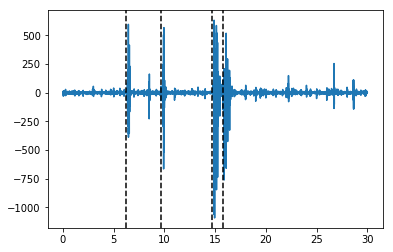

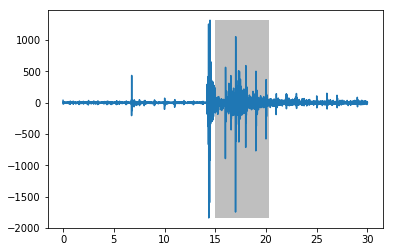

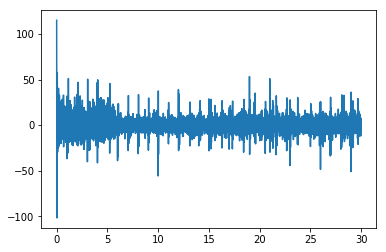

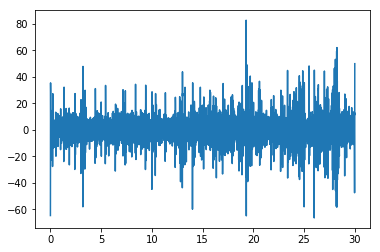

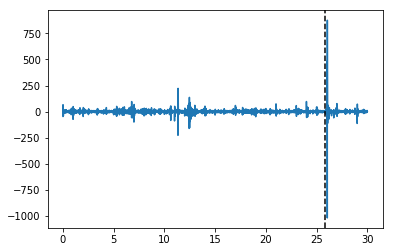

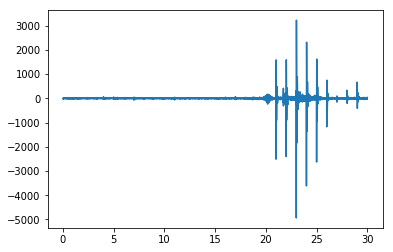

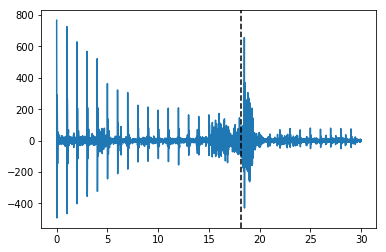

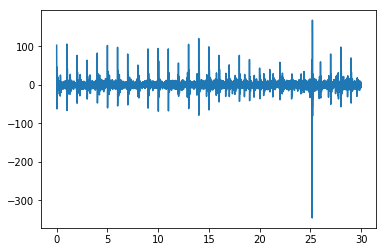

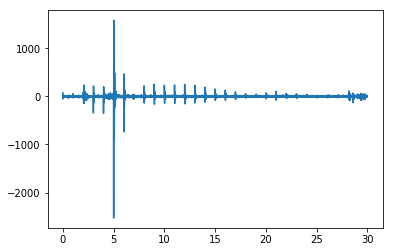

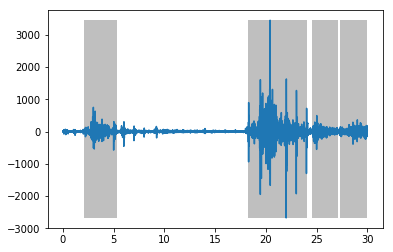

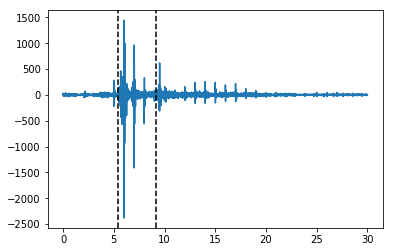

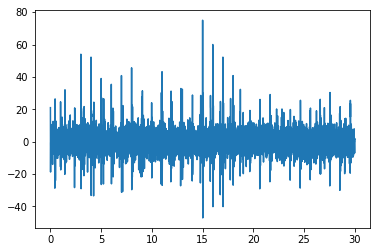

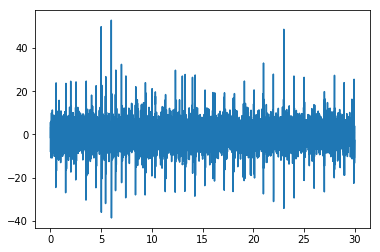

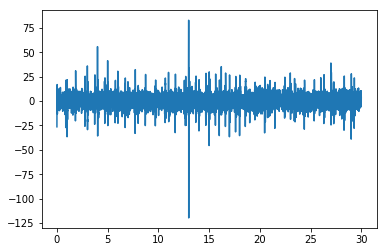

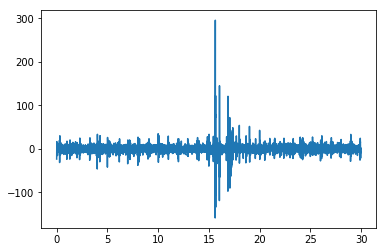

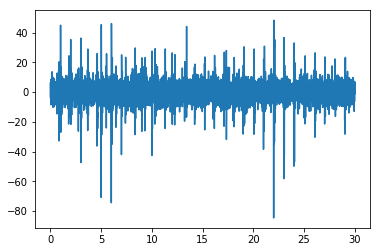

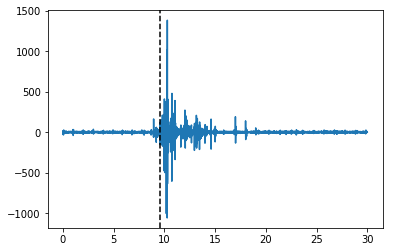

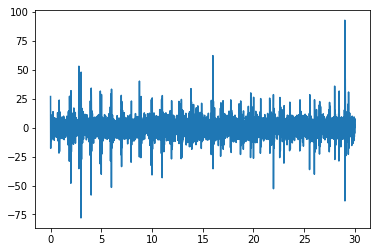

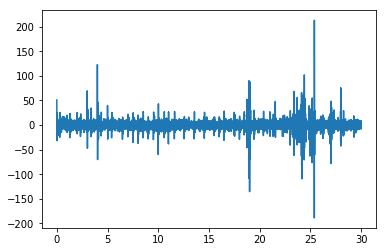

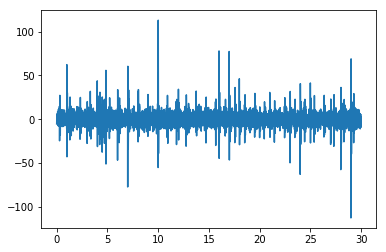

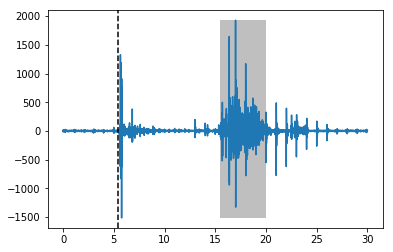

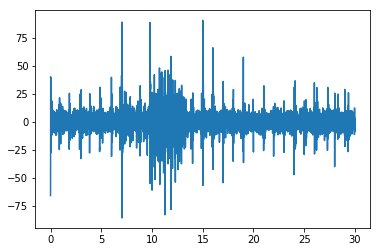

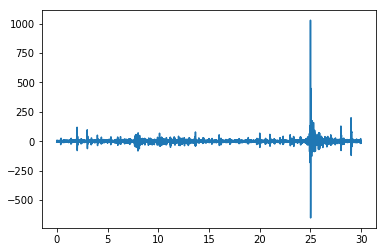

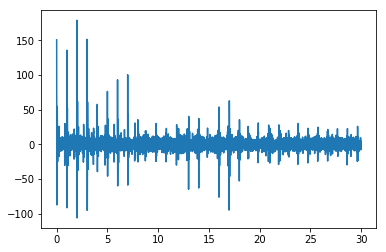

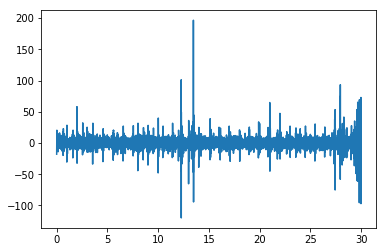

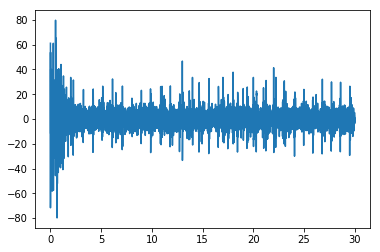

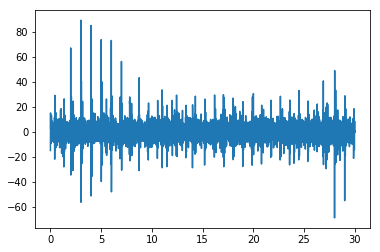

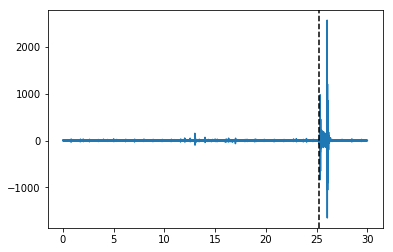

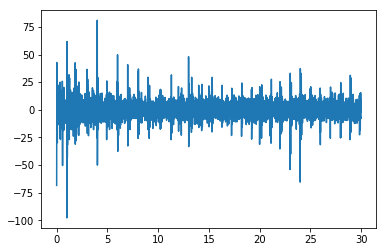

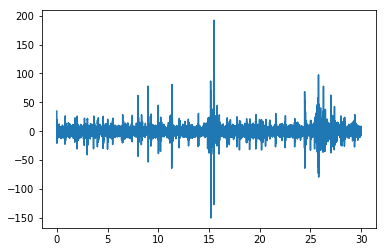

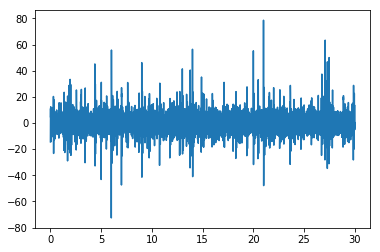

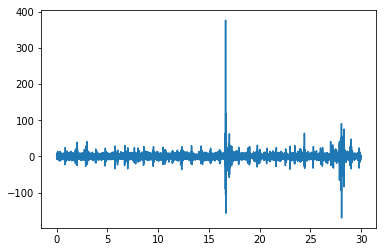

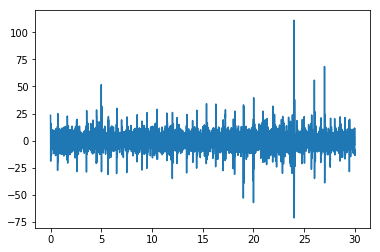

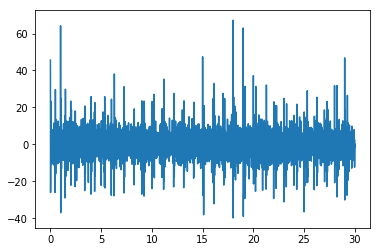

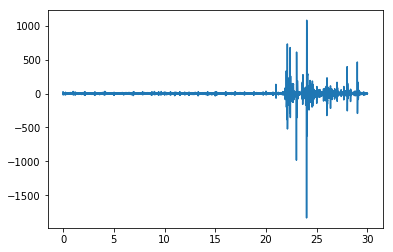

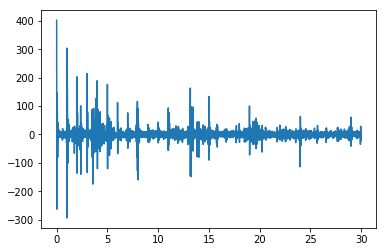

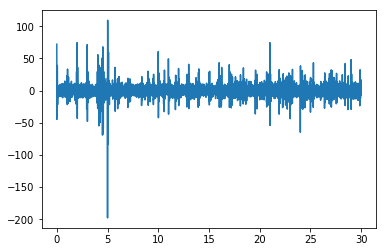

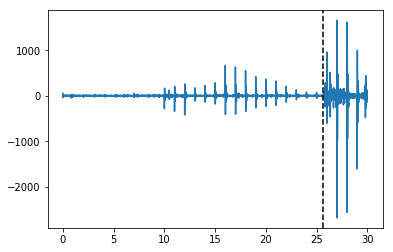

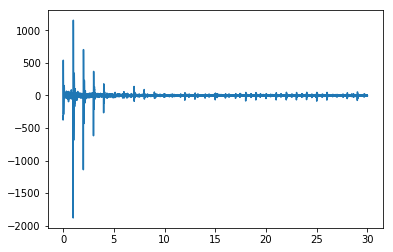

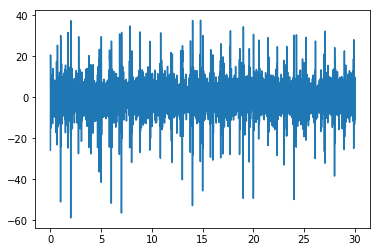

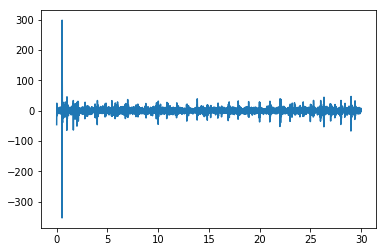

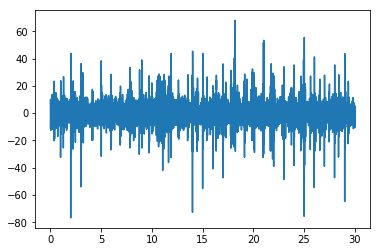

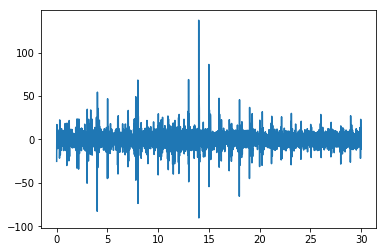

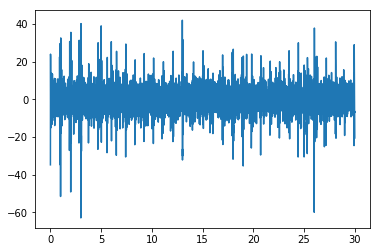

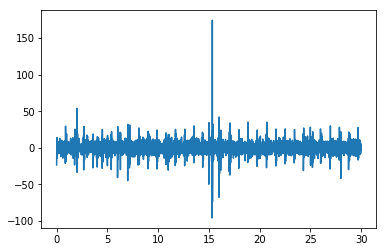

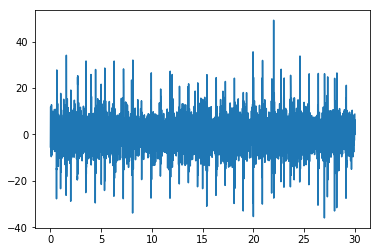

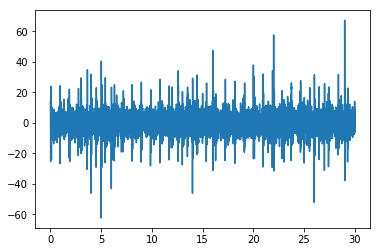

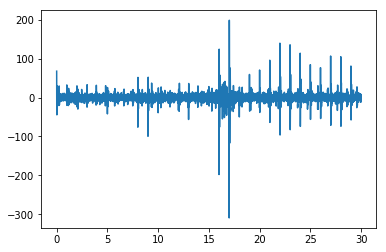

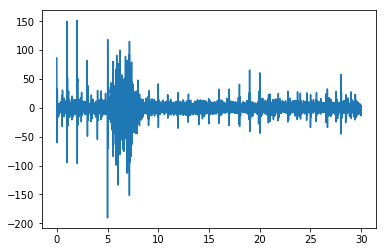

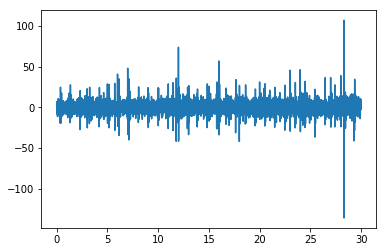

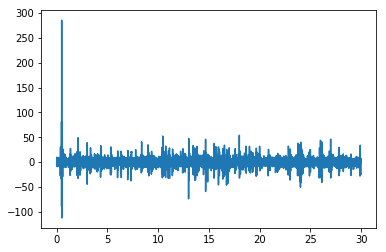

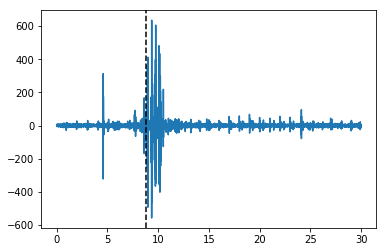

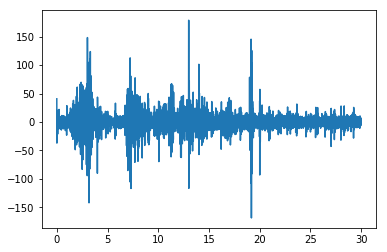

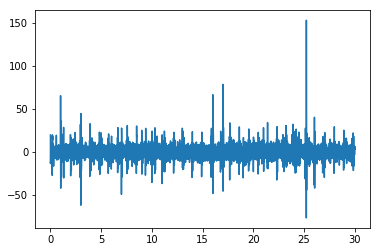

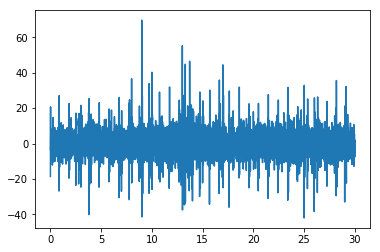

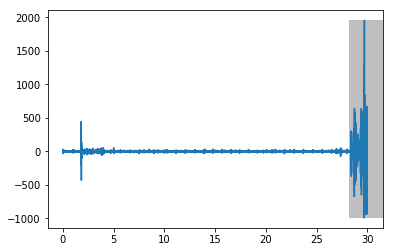

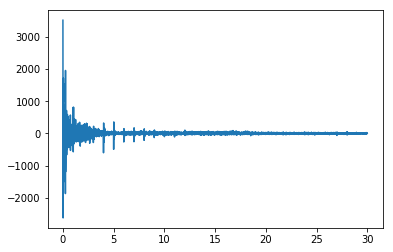

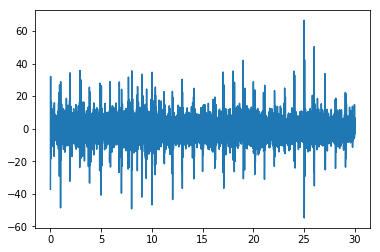

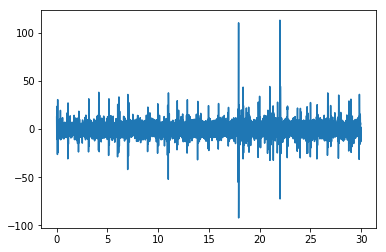

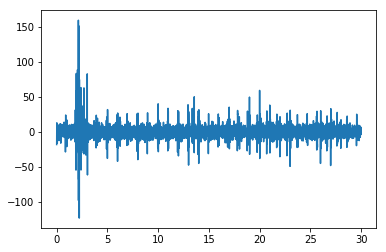

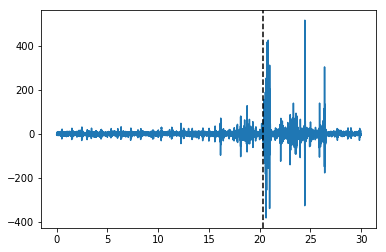

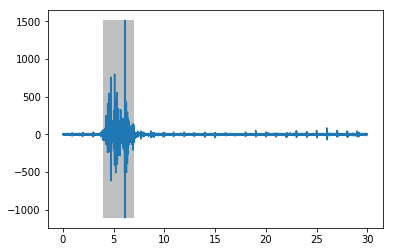

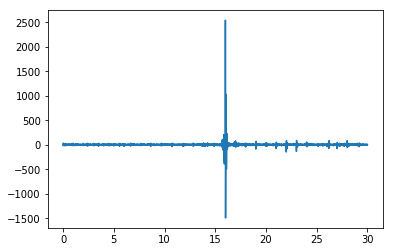

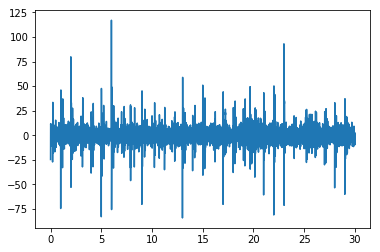

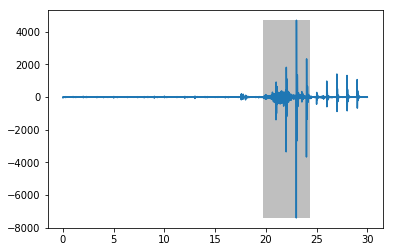

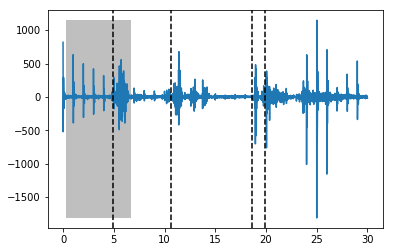

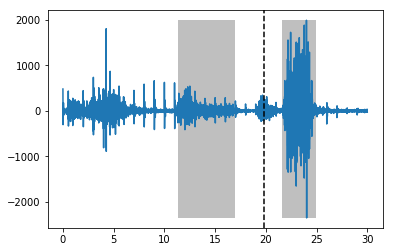

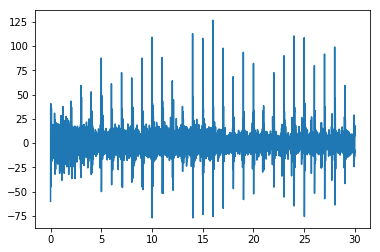

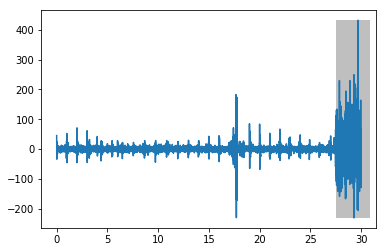

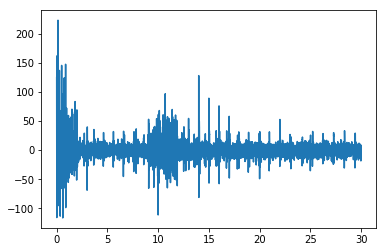

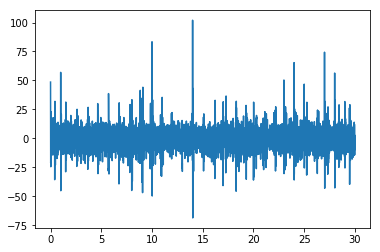

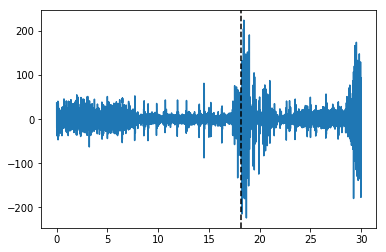

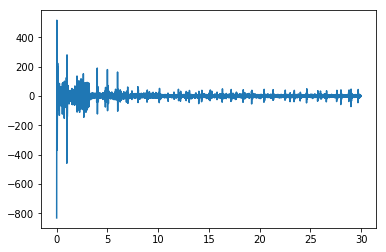

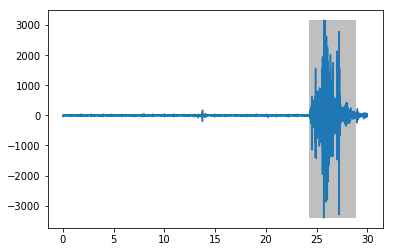

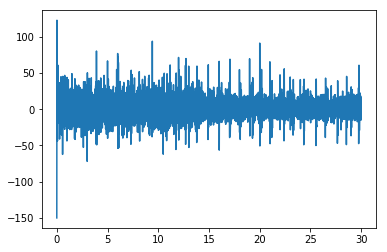

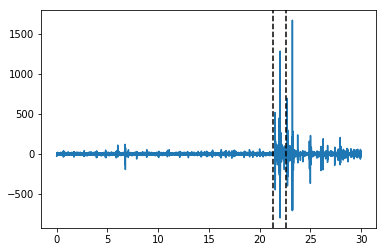

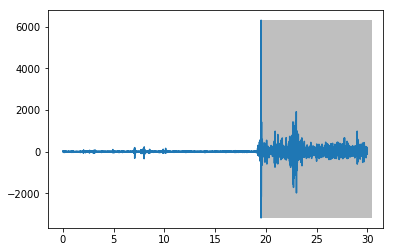

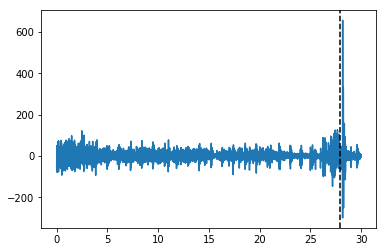

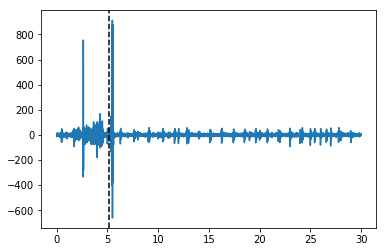

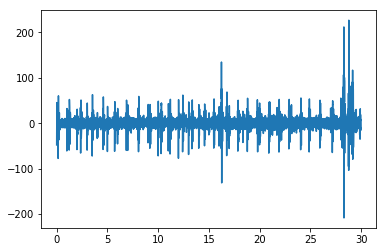

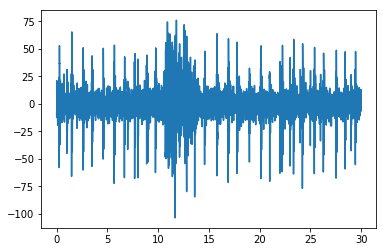

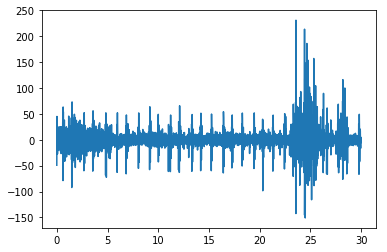

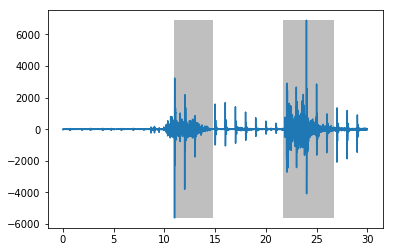

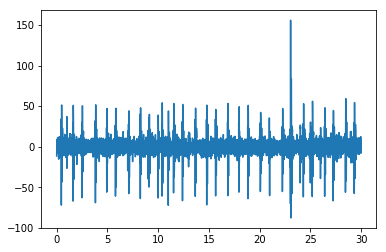

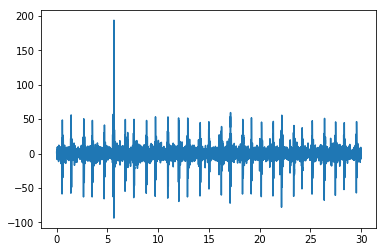

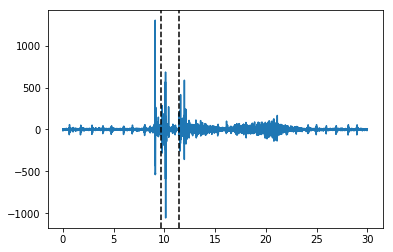

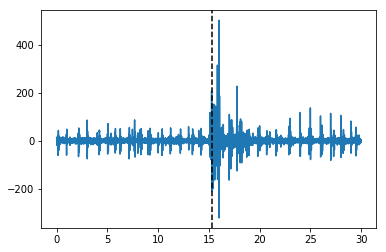

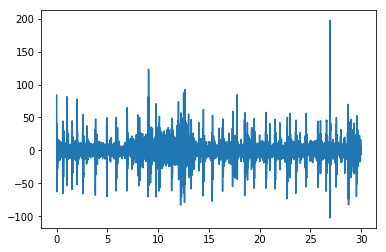

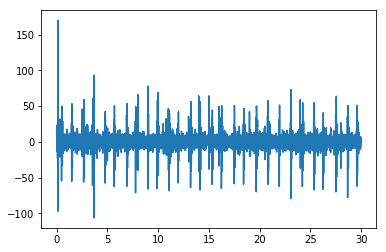

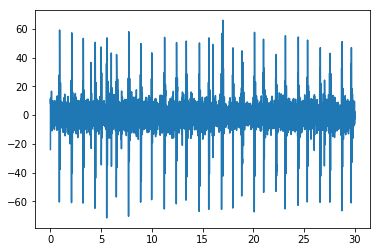

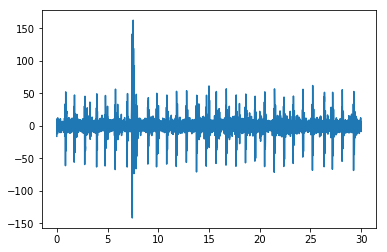

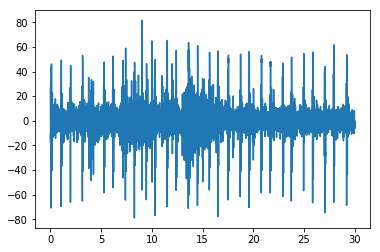

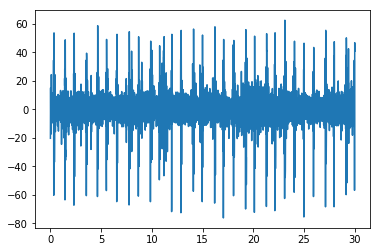

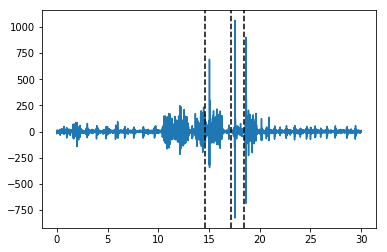

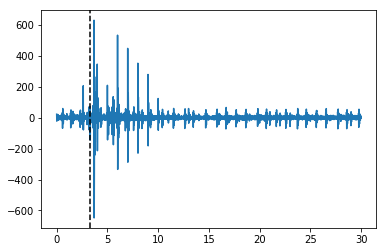

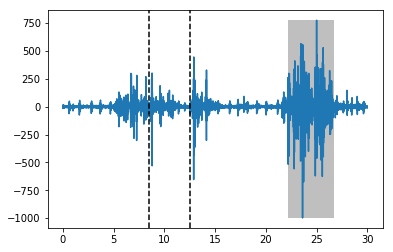

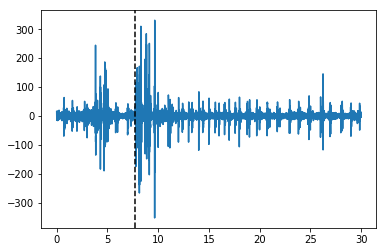

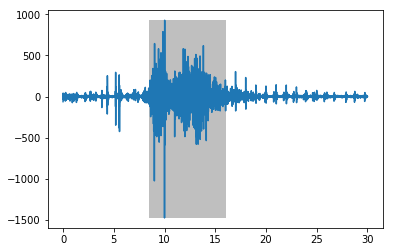

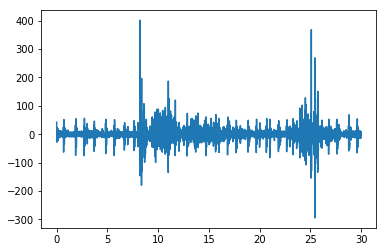

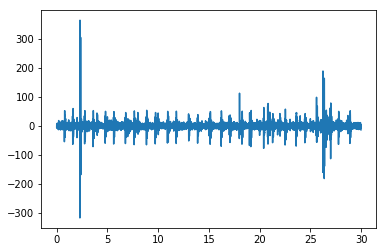

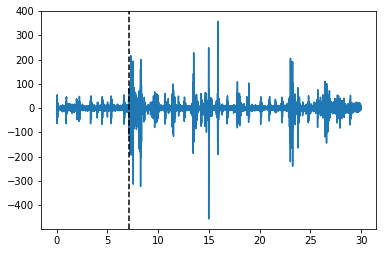

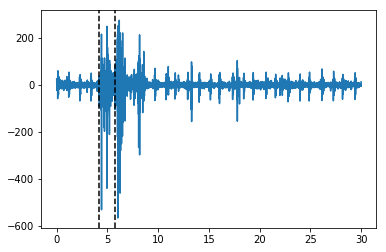

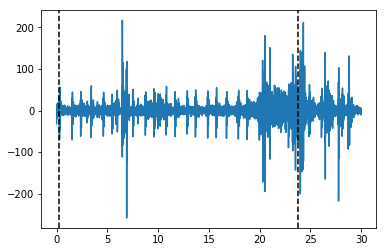

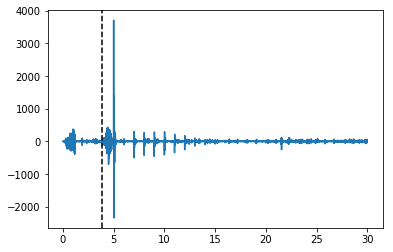

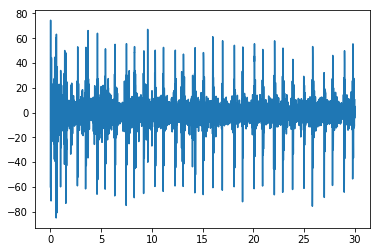

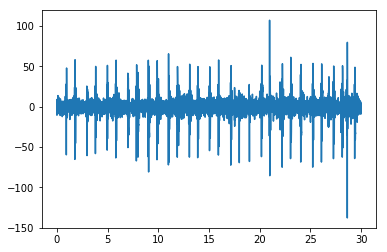

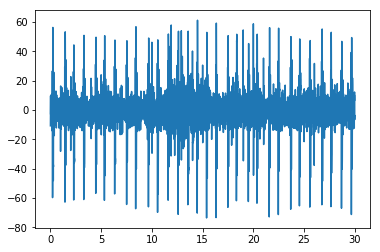

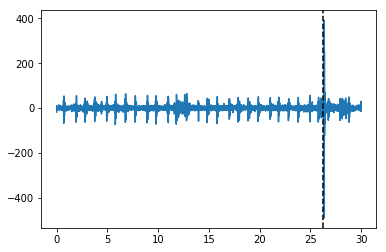

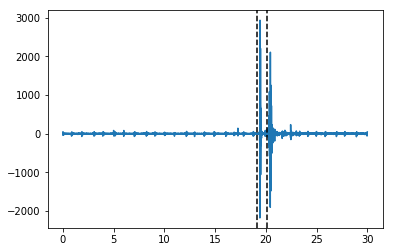

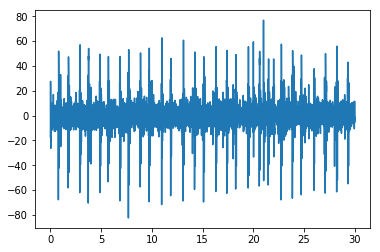

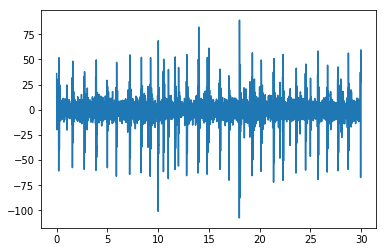

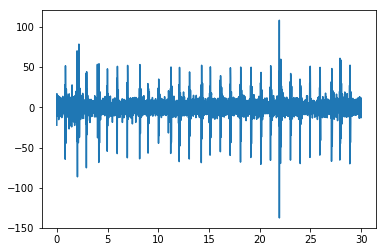

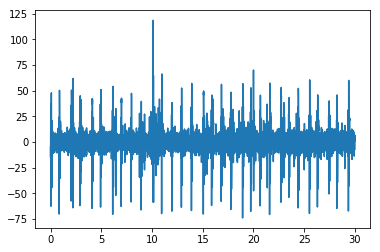

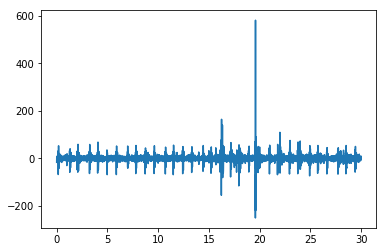

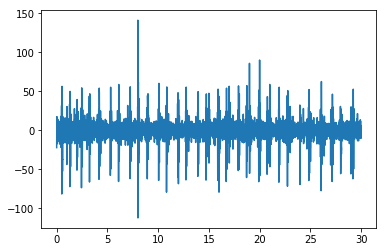

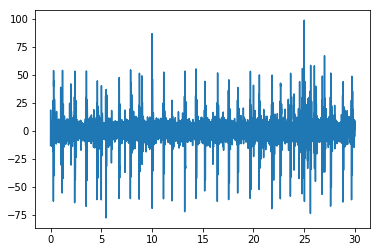

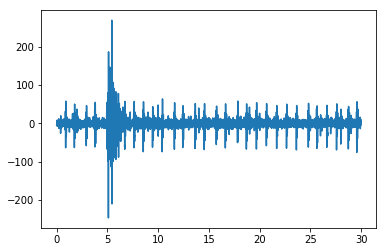

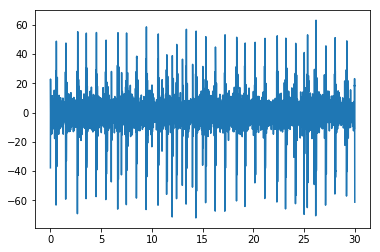

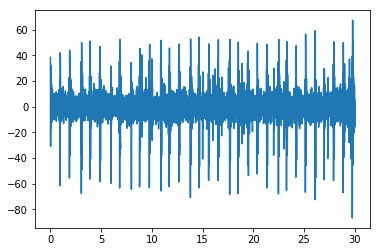

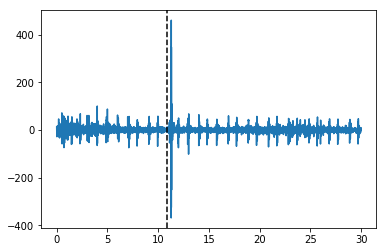

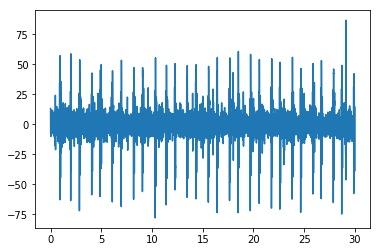

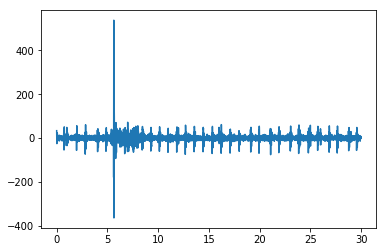

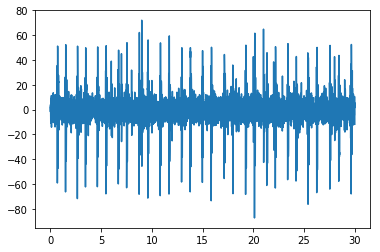

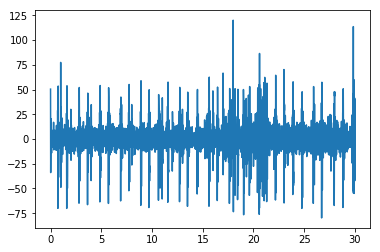

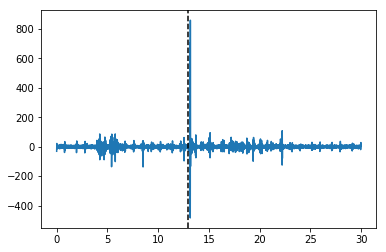

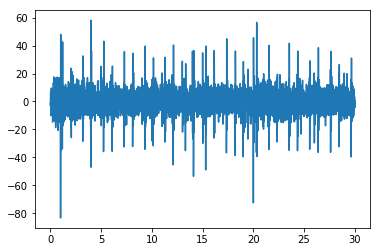

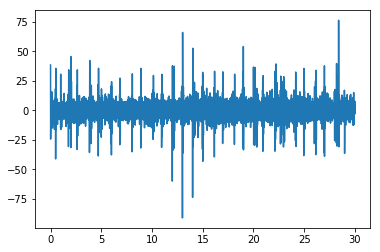

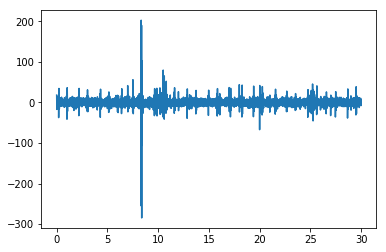

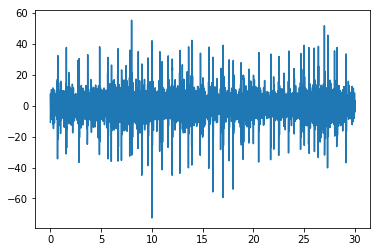

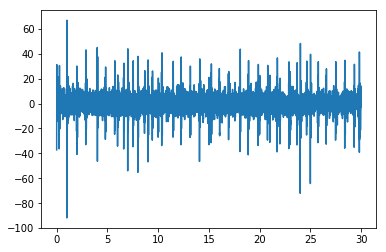

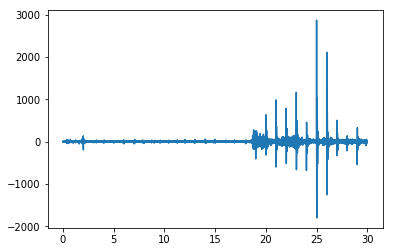

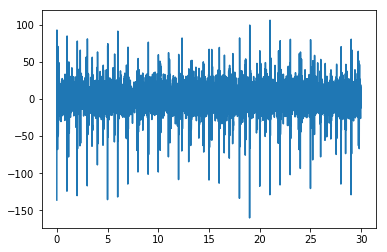

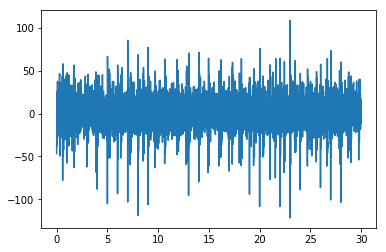

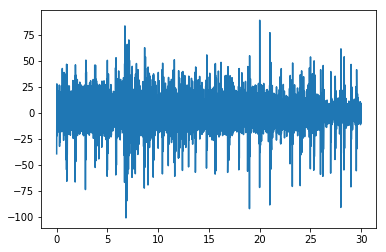

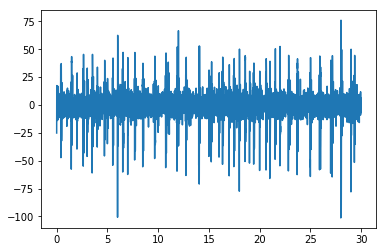

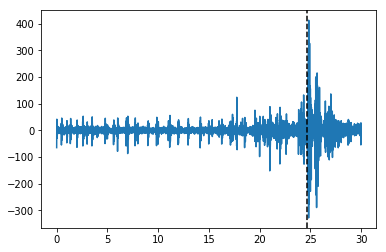

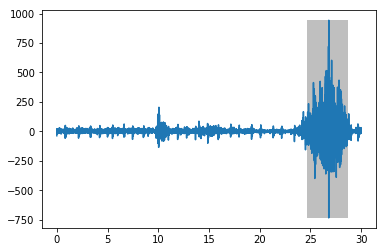

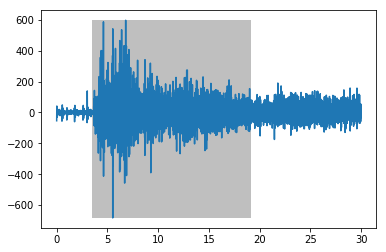

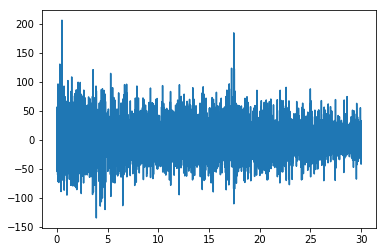

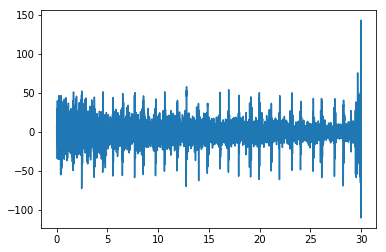

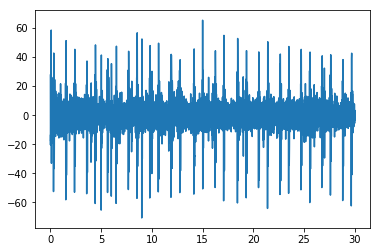

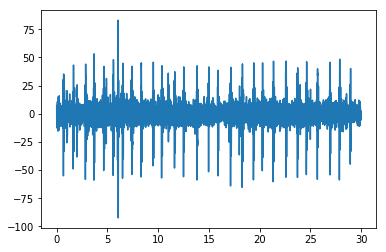

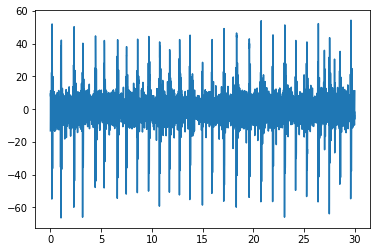

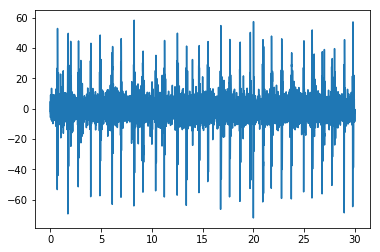

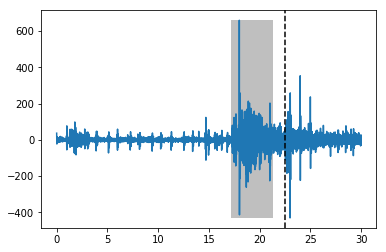

In [8]:
rem_epochs = select_rem_epochs(signal)
for epoch in rem_epochs["EpochNumber"].unique():
    plot_epoch(epoch, channels, rem_epochs)